In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Kiểm tra GPU:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Mục Đích
> Phần này chúng ta sẽ sử dụng toàn bộ tensorflow để tương tác với dữ liệu và tạo model nn cơ bản để dự báo time-series.

# Tạo dữ liệu

## Ví dụ đơn giản
> giả sử chúng ta có 20 giá trị, chúng ta sẽ cần tạo ra 1 tập dữ liệu bao gồm các chuỗi dữ liệu, mỗi chuỗi thể hiện 1 khung thời gian (time-frame). Trong 1 khung thời gian này, chúng ta sẽ tách dữ liệu ra thành dữ liệu phụ thuộc (y) là giá trị cuối cùng của chuỗi, cần được dự đoán, phần dữ liệu còn lại của chuỗi là dữ liệu không phụ thuộc (Xs) dùng để dự đoán y.

In [ ]:
# def plot_series(time, series, format="-", start=0, end=None, label=None):
#     plt.figure(figsize=(10, 6))
#     plt.plot(time[start:end], series[start:end], format, label=label)
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     if label:
#         plt.legend(fontsize=14)
#     plt.grid(True)
#     plt.show()

In [ ]:
# Tạo tập dữ liệu gốc:
dataset = tf.data.Dataset.range(20)
for i in dataset:
    print(i.numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
dataset = tf.data.Dataset.range(20)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

**Lưu ý:**
Phương pháp `window` được sử dụng để tạo ra các sequence có độ dài cố định. Có nét tương đồng với việc tạo ra các batch, tuy nhiên hoàn toàn khác về mục đích sử dụng, các sequence được tạo ra từ `window` có thể đươc coi như một instance.
Do window loop từ index đâu tiền đến index cuối cùng của 1 array, nên sẽ có những windows cuối cùng có độ dài < size của window. Để lọc bỏ các windows này, chúng ta sẽ dùng `drop_remainder = True`

In [ ]:
for window in dataset:
    print(list(window.as_numpy_iterator()))

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9, 10]
[7, 8, 9, 10, 11]
[8, 9, 10, 11, 12]
[9, 10, 11, 12, 13]
[10, 11, 12, 13, 14]
[11, 12, 13, 14, 15]
[12, 13, 14, 15, 16]
[13, 14, 15, 16, 17]
[14, 15, 16, 17, 18]
[15, 16, 17, 18, 19]


In [ ]:
# Biến window thành batch:
# Thay vì sử dụng map thì chúng ta sử dụng flat_map để sau khi áp dụng hàm, dữ liệu được trải phằng và vẫn giữ nguên thứ tự.
dataset = dataset.flat_map(lambda window: window.batch(5))

In [ ]:
for window in dataset:
    print(list(window.numpy()))

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9, 10]
[7, 8, 9, 10, 11]
[8, 9, 10, 11, 12]
[9, 10, 11, 12, 13]
[10, 11, 12, 13, 14]
[11, 12, 13, 14, 15]
[12, 13, 14, 15, 16]
[13, 14, 15, 16, 17]
[14, 15, 16, 17, 18]
[15, 16, 17, 18, 19]


In [ ]:
# Giờ chúng ta sẽ tạo ra Xs và y từ dữ liệu trên:
# Với từng batch, giá trị cuối cùng sẽ là y, còn các giá trị còn lại là Xs.
# Chúng ta có thể sử dụng hàm cho tất cả các dạng windows hoặc sử dụng lambda như dưới:
dataset = dataset.map(lambda batch: (batch[:-1], batch[-1:]))

In [ ]:
for batch in dataset:
    print(batch[0].numpy(), batch[1].numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]
[6 7 8 9] [10]
[ 7  8  9 10] [11]
[ 8  9 10 11] [12]
[ 9 10 11 12] [13]
[10 11 12 13] [14]
[11 12 13 14] [15]
[12 13 14 15] [16]
[13 14 15 16] [17]
[14 15 16 17] [18]
[15 16 17 18] [19]


In [ ]:
# Tiếp đó, chúng ta sẽ shuffle dữ liệu:
dataset = dataset.shuffle(buffer_size=20)
for batch in dataset:
    print(batch[0].numpy(), batch[1].numpy())

[ 9 10 11 12] [13]
[11 12 13 14] [15]
[2 3 4 5] [6]
[5 6 7 8] [9]
[10 11 12 13] [14]
[1 2 3 4] [5]
[12 13 14 15] [16]
[ 8  9 10 11] [12]
[4 5 6 7] [8]
[6 7 8 9] [10]
[13 14 15 16] [17]
[15 16 17 18] [19]
[ 7  8  9 10] [11]
[0 1 2 3] [4]
[14 15 16 17] [18]
[3 4 5 6] [7]


In [ ]:
# Cuối cùng, chúng ta sẽ tạo batch:
dataset = dataset.batch(4).prefetch(1)

Chúng ta có thể đóng gói tất cả các bước ở trên với 1 hàm tạo dữ liệu, tất nhiên sẽ bắt đầu bằng 1 series:

In [ ]:
def create_tfds(series, window_size=5, batch_size=32, shuffle_size=1000):
    """
        series: dữ liệu đầu vào dưới dạng series (numpy array/range)
        window_size: size của từng window view dữ liệu, ví dụ 5:  5 điểm thời gian liên tiếp
        batch_size: size của 1 batch bao gồm nhiều window: ví dụ 32: 32 chuối 5 điểm thời gian, dùng để train dữ liệu theo batch
        shuffle_size: size của 1 lần shuffle vị trí của các window.
    """
    # Biến đổi series thành tensorflow dataset:
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Tạo window:
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    # Trải phẳng:
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Tạo Xs, y:
    dataset = dataset.map(lambda o: (o[:-1], o[-1]))
    # xáo dữ liệu:
    dataset = dataset.shuffle(buffer_size=shuffle_size)
    # Tạo batch:
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
series = np.arange(200)
create_tfds(series)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

## Quay lại với ví dụ trong bài 00_basics

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()
    
# hàm tạo xu hướng: đơn giản là hàm của thời gian nhân với tỷ lệ slope (tanh):   
def create_trend(times, slope=0):
    return times * slope

# Tạo xu tính chất vụ mùa:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# Tạo dữ liệu có vụ mùa:
def create_seasonalities(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Tạo nhiễu:
def create_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed) # tạo seed
    return rnd.randn(len(time)) * noise_level

# Tạo autocorrelation:
def autocorrelation(time, amplitude, seed=None):
    phi=0.8
    rnd = np.random.RandomState(seed)
    array = rnd.randn(len(time) + 1)
    for i in range(1, len(time) + 1):
        array[i] += phi * array[i-1]
    return array[1:] * amplitude

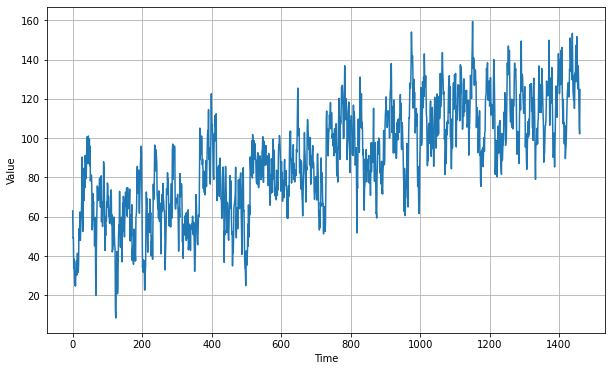

In [ ]:
times = np.arange(4*365 + 1)
baseline = 50
tseries = baseline + create_trend(times, slope = 0.05)\
+ create_seasonalities(times, period=365, amplitude=20)\
+ create_noise(times, seed=42)\
+ autocorrelation(times, amplitude=10)
plot_series(times, tseries)

In [ ]:
dataset = create_tfds(tseries)

In [ ]:
for batch in dataset.take(1):
    print(batch[0], batch[1])

tf.Tensor(
[[ 67.28255276  65.28595739  89.91375908  77.33027365  78.59050194]
 [ 95.89619152  93.15046152  72.45119158  46.99283779  34.1940454 ]
 [ 65.00297407  55.54769677  49.7679708   58.59521979  68.43270265]
 [ 82.31788662  71.71689733  65.6754218   66.49730429  51.31453015]
 [116.11634807 112.05253329  92.42862582 119.43138655  94.71240853]
 [ 81.2754743   97.72402297  83.12108931  61.83375301  62.14525446]
 [ 52.80360156  59.27077424  59.58646926  69.70088339  90.39464661]
 [ 79.52831771  82.70459147  91.65925237 102.82098096  94.62262439]
 [ 32.92993104  42.66265045  35.24353158  40.86187645  41.90458511]
 [103.49074622 104.35244357 104.71685836  90.93937078  97.52568172]
 [116.51066571 123.309929   112.3866416  102.62368507 110.07138258]
 [ 45.08017507  66.00401454  49.52140474  52.33542136  65.49079222]
 [ 35.35142075  20.8282067   24.31392009  38.16707821  50.35934   ]
 [ 89.87236604  83.27922015  79.22888837  69.09434695  69.48156544]
 [ 87.01689618 101.09518887  93.05223

Như ở trên, chúng ta đã lấy sample của  1 batch bao gồm 32 windows, 32ys. Trong mỗi windows chúng ta có 5 giá trị liên tiếp theo thời gian, giá trị y tương ứng chính là giá trị tiếp theo của chuối thời gian này. Ở đây chúng ta cũng đã xóa dữ liệu (shuffle) nên không thể quan sát được chuỗi các window liên tiếp nối nhau.

# Tạo mô hình NN đơn giản

In [ ]:
# Tạo dữ liệu:
window_size = 20
train_tfds = create_tfds(tseries[:3*365], window_size=window_size)
valid_tfds = create_tfds(tseries[3*365:], window_size=window_size)

In [ ]:
# Tạo mô hình đơn giản:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model = keras.Sequential([keras.layers.Dense(1, input_shape=[window_size])])
model.compile(optimizer=optimizer, loss='mse')
model.fit(train_tfds, epochs=300, validation_data=valid_tfds, verbose=0)

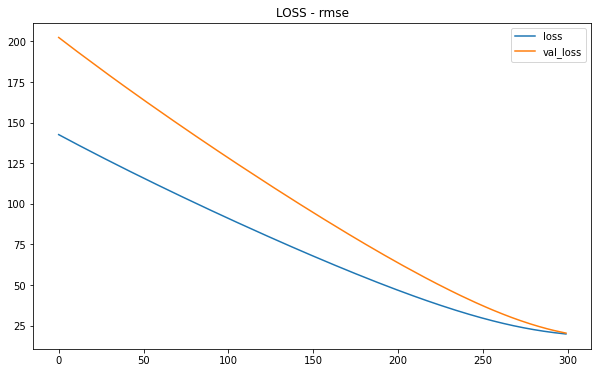

In [ ]:
history = model.history
plt.figure(figsize=(10,6))
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.legend(list(history.history.keys()))
plt.title("LOSS - rmse")
plt.show()

# RNN
> RNN được áp dụng tương đối phổ biến với NLP và time-series, đặc biệt là LSTM. Trong phần này chúng ta sẽ tập trung vào tạo model đơn giản và nâng cao vs LSTM.
Ngoài ra, chúng ta cũng sẽ áp dụng một số kỹ năng đơn giản về tuning learning rate để cải thiện loss trong quá trình train.

## RNN cơ bản
> Với model cơ bản, chúng ta sẽ chỉ dùng 

In [ ]:
model = keras.Sequential()
# Tạo layer lambda với mục đích tăng dimension cho X
model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, -1), input_shape=[None]))

# Tạo 2 layer RNN cơ bản trồng lên nhau:
model.add(keras.layers.SimpleRNN(window_size*2, return_sequences=True))
model.add(keras.layers.SimpleRNN(window_size*2))

# Tạo layer Dense:
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 100.))

# Tạo learning rate schedule:
# Tạo một lr schedule thỏa mãn cứ sau 20 epochs, lr sẽ tăng lên với mũ 10, bắt đầu từ 1e-8.
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Sử dụng SGD optimizer với momentum = 0.9 (có thể dùng nesterov momentum)
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9, nesterov=True)

# Compile model và chạy
model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mse'])
model.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 11s 234ms/step - loss: 119.6692 - mse: 14916.8223 - val_loss: 149.5902 - val_mse: 22781.0488
Epoch 2/100
34/34 [==============================] - 8s 224ms/step - loss: 115.3361 - mse: 13888.3213 - val_loss: 145.1072 - val_mse: 21458.2617
Epoch 3/100
34/34 [==============================] - 8s 223ms/step - loss: 110.6959 - mse: 12844.4805 - val_loss: 140.5504 - val_mse: 20154.6641
Epoch 4/100
34/34 [==============================] - 8s 224ms/step - loss: 105.9136 - mse: 11800.7686 - val_loss: 135.8045 - val_mse: 18840.7188
Epoch 5/100
34/34 [==============================] - 8s 217ms/step - loss: 100.8971 - mse: 10767.9541 - val_loss: 130.7823 - val_mse: 17498.7930
Epoch 6/100
34/34 [==============================] - 8s 219ms/step - loss: 95.5760 - mse: 9719.9033 - val_loss: 125.4111 - val_mse: 16119.0391
Epoch 7/100
34/34 [==============================] - 8s 230ms/step - loss: 89.8845 - mse: 8658.9951 - val_loss: 119.6292 - val_mse:

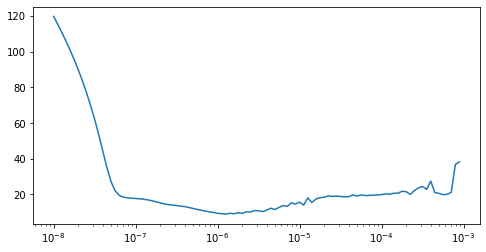

In [ ]:
# Vẽ đồ thị learning rate và loss:
history = model.history
plt.figure(figsize=(8,4))
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

**Lưu ý:**
Chúng ta có thể thấy với đồ thị trên, loss ở ngưỡng thấp nhất khi learning_rate tầm 2e-6. Tuy nhiên, chúng ta có thể lấy learning rate ở mức 1e-6 hoặc 5e-7 khi loss có mức giảm tương đối lớn. Tất nhiên, khi learning rate càng nhỏ thì việc chúng ta phải dùng nhiều epochs hơn để train model là việc hiển nhiên, vậy, chúng ta sẽ chọn lr ở mức 3e-6 khi loss bắt đầu chuyển trạng thái tăng dần.

**`Keras.backend.clear_session`**:

Khi tạo rất nhiều model khác nhau, Keras sẽ vẫn lưu trạng thái của các model này. Điều này dẫn đến việc rất nhiều model, layers, không được định danh sẽ có thêm hậu tố là số ví dụ: sequential_1, sequential_2... hay dense_1...
Ví dụ như:

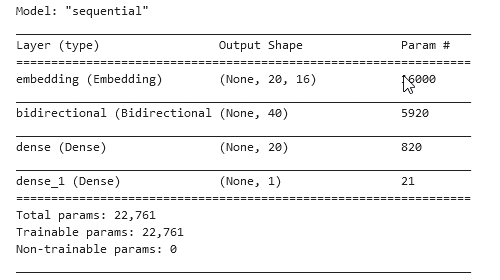

và:

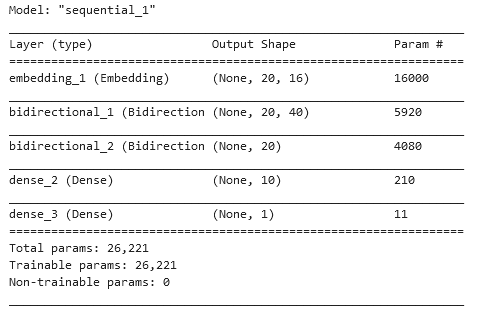

và:

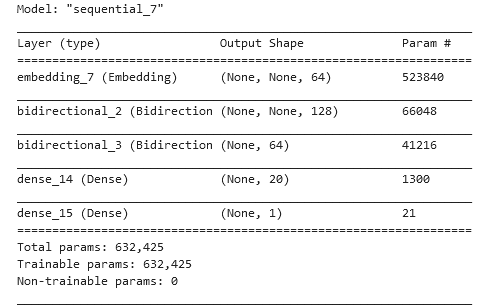

Việc này có thể khiến bộ nhớ của chúng ta bị đầy. Trong tình huống này, nếu chúng ta xây dựng lại một DNN có cấu trúc tương tự với cấu trúc cũ mà không muốn lưu các cấu trúc cũ, chúng ta có thể dùng phương pháp `clear_session` của keras backend để giải phóng bộ nhớ này.


In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.Sequential()
# Tạo layer lambda với mục đích tăng dimension cho X
model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, -1), input_shape=[None]))

# Tạo 2 layer RNN cơ bản trồng lên nhau:
model.add(keras.layers.SimpleRNN(window_size*2, return_sequences=True))
model.add(keras.layers.SimpleRNN(window_size*2))

# Tạo layer Dense:
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 100.))

# Sử dụng SGD optimizer với momentum = 0.9 (có thể dùng nesterov momentum)
optimizer = keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9, nesterov=True)

# Compile model và chạy. Giờ chúng ta sẽ ko dùng lr scheduler nữa:
model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mse'])
model.fit(train_tfds, epochs=400, validation_data=valid_tfds)

Epoch 1/400
34/34 [==============================] - 9s 229ms/step - loss: 15.5274 - mse: 444.1969 - val_loss: 20.3646 - val_mse: 638.9203
Epoch 2/400
34/34 [==============================] - 8s 227ms/step - loss: 9.8506 - mse: 177.3311 - val_loss: 16.3862 - val_mse: 430.3503
Epoch 3/400
34/34 [==============================] - 8s 224ms/step - loss: 9.3524 - mse: 160.2582 - val_loss: 14.1422 - val_mse: 322.3783
Epoch 4/400
34/34 [==============================] - 8s 228ms/step - loss: 9.1547 - mse: 151.7552 - val_loss: 15.9006 - val_mse: 404.5759
Epoch 5/400
34/34 [==============================] - 8s 223ms/step - loss: 9.0931 - mse: 149.5999 - val_loss: 15.6816 - val_mse: 395.4530
Epoch 6/400
34/34 [==============================] - 8s 226ms/step - loss: 9.0834 - mse: 148.0943 - val_loss: 15.3130 - val_mse: 377.1149
Epoch 7/400
34/34 [==============================] - 8s 227ms/step - loss: 8.6999 - mse: 136.8430 - val_loss: 15.3670 - val_mse: 376.1228
Epoch 8/400
34/34 [==============

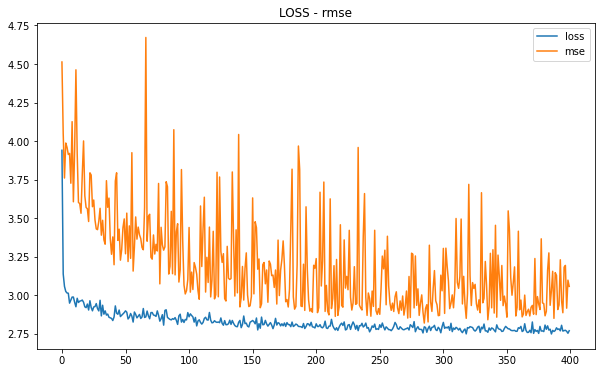

In [ ]:
history = model.history
plt.figure(figsize=(10,6))
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.legend(list(history.history.keys()))
plt.title("LOSS - rmse")
plt.show()

## RNN với LSTM

In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 100.))

model.compile(optimizer=keras.optimizers.SGD(lr=3e-6, momentum=.9, nesterov=True), loss=keras.losses.Huber(), metrics=['mse'])
model.summary()        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_tfds, epochs=400, validation_data=valid_tfds)

Epoch 1/400
34/34 [==============================] - 11s 141ms/step - loss: 27.6498 - mse: 1440.2960 - val_loss: 29.0524 - val_mse: 1127.3290
Epoch 2/400
34/34 [==============================] - 4s 111ms/step - loss: 15.9558 - mse: 429.1250 - val_loss: 25.2076 - val_mse: 893.0543
Epoch 3/400
34/34 [==============================] - 4s 111ms/step - loss: 15.3421 - mse: 398.0136 - val_loss: 25.0524 - val_mse: 882.0229
Epoch 4/400
34/34 [==============================] - 4s 112ms/step - loss: 14.7923 - mse: 375.0486 - val_loss: 23.6934 - val_mse: 803.4722
Epoch 5/400
34/34 [==============================] - 4s 111ms/step - loss: 14.4750 - mse: 357.1027 - val_loss: 22.3403 - val_mse: 727.5364
Epoch 6/400
34/34 [==============================] - 4s 111ms/step - loss: 14.1565 - mse: 346.7139 - val_loss: 20.1551 - val_mse: 609.1389
Epoch 7/400
34/34 [==============================] - 4s 110ms/step - loss: 13.8420 - mse: 331.2085 - val_loss: 23.5458 - val_mse: 791.1821
Epoch 8/400
34/34 [=====

In [ ]:
history = model.history

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [ ]:
def plot_history(history, metrics:str='Accuracy'):
    item_dict = {'Loss': ['loss', 'val_loss'], f'{metrics}': ['mse', f'val_{metrics.lower()}']}
    plot_list = ['Loss', f'{metrics}']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

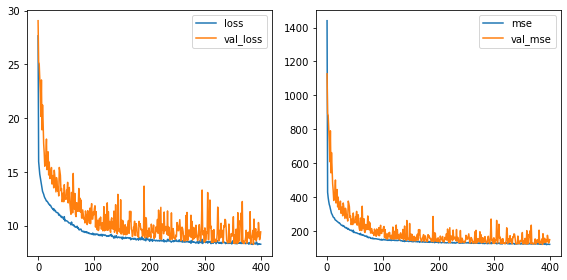

In [ ]:
plot_history(history, 'mse')

**Vẽ so sánh kết quả:**

In [ ]:
y_hat = model.predict(valid_tfds)

In [ ]:
y_true = []
for tfds in valid_tfds:
    y = tfds[1].numpy()
    for i in y:
        y_true.append(i)
y_true = np.array(y_true)

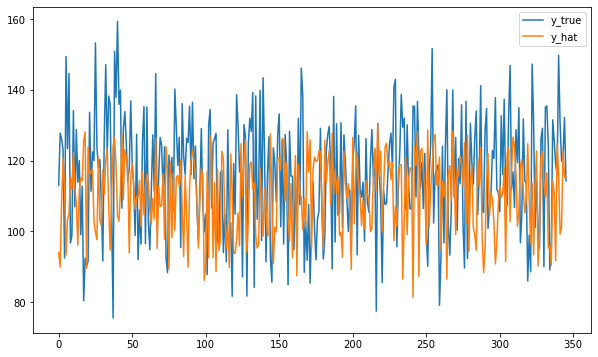

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_true)
plt.plot(y_hat)
plt.legend(['y_true', 'y_hat'])